# Test: `river` Hyperparameter Tuning: Hoeffding Adaptive Tree Regressor with Friedman Drift Data {#sec-river-hpt}

This chapter demonstrates hyperparameter tuning for `river`'s `Hoeffding Adaptive Tree Regressor` with the Friedman drift data set [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). The `Hoeffding Adaptive Tree Regressor` is a decision tree that uses the Hoeffding bound to limit the number of splits evaluated at each node. The `Hoeffding Adaptive Tree Regressor` is a regression tree, i.e., it predicts a real value for each sample. The `Hoeffding Adaptive Tree Regressor` is a drift aware model, i.e., it can handle concept drifts.


## Setup {#sec-setup-13}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, size of the data set, and the experiment name.

* `MAX_TIME`: The maximum run time in seconds for the hyperparameter tuning process.
* `INIT_SIZE`: The initial design size for the hyperparameter tuning process.
* `PREFIX`: The prefix for the experiment name.
* `K`: The factor that determines the number of samples in the data set.

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `K` is the multiplier for the number of samples. If it is set to 1, then `100_000`samples are taken. It is set to 0.1 for demonstration purposes. For real experiments, this should be increased to at least 1.
:::


In [1]:
MAX_TIME = 1
INIT_SIZE = 5
PREFIX="24-river"
K = 0.05
import pprint

In [2]:
#| echo: false
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython and spotRiver).
* The hyperparameter software SPOT is available in Python. It was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).
* This notebook demonstrates hyperparameter tuning for `river`. It is based on the notebook "Incremental decision trees in river: the Hoeffding Tree case", see: [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters).
* Here we will use the river `HTR` and `HATR` functions as in "Incremental decision trees in river: the Hoeffding Tree case", see: [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters).

## Initialization of the `fun_control` Dictionary

`spotPython` supports the visualization of the hyperparameter tuning process with TensorBoard. The following example shows how to use TensorBoard with `spotPython`.
The `fun_control` dictionary is the central data structure that is used to control the optimization process. It is initialized as follows:


In [3]:
from spotPython.utils.init import fun_control_init
fun_control = fun_control_init(
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    max_time=MAX_TIME,
    fun_evals=inf,
    tolerance_x = np.sqrt(np.spacing(1)))
pprint.pprint(fun_control)

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_03_11_22_07_12
Created spot_tensorboard_path: runs/spot_logs/24-river_p040025_2024-03-11_22-07-12 for SummaryWriter()
{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '24-river',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': None,
 '_L_out': None,
 '_torchmetric': None,
 'accelerator': 'auto',
 'converters': None,
 'core_model': None,
 'core_model_name': None,
 'counter': 0,
 'data': None,
 'data_dir': './data',
 'data_module': None,
 'data_set': None,
 'data_set_name': None,
 'design': None,
 'device': None,
 'devices': 1,
 'enable_progress_bar': False,
 'eval': None,
 'fun_evals': inf,
 'fun_repeats': 1,
 'horizon': None,
 'infill_criterion': 'y',
 'k_folds': 3,
 'log_graph': False,
 'log_level': 50,
 'loss_function': None,
 'lower': None,
 'max_time': 1,
 'metric_params': {},
 'metric_river': None,
 'metric_sklearn': None,
 'metric_torch': None,
 'model_dic

::: {.callout-tip}
#### Tip: TensorBoard
* Since the `spot_tensorboard_path` argument is not `None`, which is the default, `spotPython` will log the optimization process in the TensorBoard folder.
* @sec-tensorboard-10 describes how to start TensorBoard and access the TensorBoard dashboard.
* The `TENSORBOARD_CLEAN` argument is set to `True` to archive the TensorBoard folder if it already exists. This is useful if you want to start a hyperparameter tuning process from scratch.
If you want to continue a hyperparameter tuning process, set `TENSORBOARD_CLEAN` to `False`. Then the TensorBoard folder will not be archived and the old and new TensorBoard files will shown in the TensorBoard dashboard.
:::

## Load Data: The Friedman Drift Data

We will use the Friedman synthetic dataset with concept drifts [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/). Each observation is composed of ten features. Each feature value is sampled uniformly in [0, 1]. Only the first five features are relevant. The target is defined by different functions depending on the type of the drift. Global Recurring Abrupt drift will be used, i.e., the concept drift appears over the whole instance space. There are two points of concept drift. At the second point of drift the old concept reoccurs.

The following parameters are used to generate and handle the data set:

* horizon: The prediction horizon in hours.
* n_samples: The number of samples in the data set.
* p_1: The position of the first concept drift.
* p_2: The position of the second concept drift.
* position: The position of the concept drifts.
* n_train: The number of samples used for training.


In [4]:
horizon = 7*24
n_samples = int(K*100_000)
p_1 = int(K*25_000)
p_2 = int(K*50_000)
position=(p_1, p_2)
n_train = 1_000

In [5]:
from river.datasets import synth
import pandas as pd
dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=123
)

* We will use `spotRiver`'s `convert_to_df` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/utils/data_conversion.py) to convert the `river` data set to a `pandas` data frame.


In [6]:
from spotRiver.utils.data_conversion import convert_to_df
target_column = "y"
df = convert_to_df(dataset, target_column=target_column, n_total=n_samples)

* Add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column of the dataframe.
* Then split the data frame into a training and test data set. The train and test data sets are stored in the `fun_control` dictionary.


In [7]:
from spotPython.hyperparameters.values import set_control_key_value
df.columns = [f"x{i}" for i in range(1, 11)] + ["y"]
set_control_key_value(control_dict=fun_control,
                        key="train",
                        value=df[:n_train],
                        replace=True)
set_control_key_value(fun_control, "test", df[n_train:], True)
set_control_key_value(fun_control, "n_samples", n_samples, replace=True)
set_control_key_value(fun_control, "target_column", target_column, replace=True)
pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '24-river',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': None,
 '_L_out': None,
 '_torchmetric': None,
 'accelerator': 'auto',
 'converters': None,
 'core_model': None,
 'core_model_name': None,
 'counter': 0,
 'data': None,
 'data_dir': './data',
 'data_module': None,
 'data_set': None,
 'data_set_name': None,
 'design': None,
 'device': None,
 'devices': 1,
 'enable_progress_bar': False,
 'eval': None,
 'fun_evals': inf,
 'fun_repeats': 1,
 'horizon': None,
 'infill_criterion': 'y',
 'k_folds': 3,
 'log_graph': False,
 'log_level': 50,
 'loss_function': None,
 'lower': None,
 'max_time': 1,
 'metric_params': {},
 'metric_river': None,
 'metric_sklearn': None,
 'metric_torch': None,
 'model_dict': {},
 'n_points': 1,
 'n_samples': 5000,
 'n_total': None,
 'noise': False,
 'num_workers': 0,
 'ocba_delta': 0,
 'oml_grace_period': None,
 'optimizer': None,
 'path': None,
 'prep_model': 

## Specification of the Preprocessing Model

* We use the `StandardScaler` [[SOURCE]](https://riverml.xyz/dev/api/preprocessing/StandardScaler/) from `river` as the preprocessing model. The `StandardScaler` is used to standardize the data set, i.e., it has zero mean and unit variance.


In [8]:
from river import preprocessing
prep_model = preprocessing.StandardScaler()
set_control_key_value(fun_control, "prep_model", prep_model, replace=True)
pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '24-river',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': None,
 '_L_out': None,
 '_torchmetric': None,
 'accelerator': 'auto',
 'converters': None,
 'core_model': None,
 'core_model_name': None,
 'counter': 0,
 'data': None,
 'data_dir': './data',
 'data_module': None,
 'data_set': None,
 'data_set_name': None,
 'design': None,
 'device': None,
 'devices': 1,
 'enable_progress_bar': False,
 'eval': None,
 'fun_evals': inf,
 'fun_repeats': 1,
 'horizon': None,
 'infill_criterion': 'y',
 'k_folds': 3,
 'log_graph': False,
 'log_level': 50,
 'loss_function': None,
 'lower': None,
 'max_time': 1,
 'metric_params': {},
 'metric_river': None,
 'metric_sklearn': None,
 'metric_torch': None,
 'model_dict': {},
 'n_points': 1,
 'n_samples': 5000,
 'n_total': None,
 'noise': False,
 'num_workers': 0,
 'ocba_delta': 0,
 'oml_grace_period': None,
 'optimizer': None,
 'path': None,
 'prep_model': 

## SelectSelect Model (`algorithm`) and `core_model_hyper_dict`

`spotPython` hyperparameter tuning approach uses two components:

1. a model (class) and 
2. an associated hyperparameter dictionary. 

Here, the `river` model class `HoeffdingAdaptiveTreeRegressor` [[SOURCE]](https://riverml.xyz/dev/api/tree/HoeffdingAdaptiveTreeRegressor/) is selected.

The corresponding hyperparameters are loaded from the associated dictionary, which is stored as a JSON file [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json). The JSON file contains hyperparameter type information, names, and bounds. 

The method `add_core_model_to_fun_control` adds the model and the hyperparameter dictionary to the `fun_control` dictionary.

Alternatively, you can load a local hyper_dict. Simply set `river_hyper_dict.json` as the filename. If `filename`is set to `None`, which is the default, the hyper_dict [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json) is loaded from the `spotRiver` package.


In [9]:
# from river.tree import HoeffdingAdaptiveTreeRegressor
# from spotRiver.data.river_hyper_dict import RiverHyperDict
# from spotPython.hyperparameters.values import add_core_model_to_fun_control
# core_model  = HoeffdingAdaptiveTreeRegressor
# add_core_model_to_fun_control(core_model=core_model,
#                               fun_control=fun_control,
#                               hyper_dict=RiverHyperDict,
#                               filename=None)

In [10]:
# from river.tree import HoeffdingTreeRegressor
# from spotRiver.data.river_hyper_dict import RiverHyperDict
# from spotPython.hyperparameters.values import add_core_model_to_fun_control
# core_model  = HoeffdingTreeRegressor
# add_core_model_to_fun_control(core_model=core_model,
#                               fun_control=fun_control,
#                               hyper_dict=RiverHyperDict,
#                               filename=None)

In [11]:
from spotPython.hyperparameters.values import add_core_model_to_fun_control
import sys
sys.path.insert(0, './userModel')
import river.tree
import river_hyper_dict
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=river.tree.HoeffdingTreeRegressor,
                              hyper_dict=river_hyper_dict.RiverHyperDict)
pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '24-river',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': None,
 '_L_out': None,
 '_torchmetric': None,
 'accelerator': 'auto',
 'converters': None,
 'core_model': <class 'river.tree.hoeffding_tree_regressor.HoeffdingTreeRegressor'>,
 'core_model_hyper_dict': {'binary_split': {'core_model_parameter_type': 'bool',
                                            'default': 0,
                                            'levels': [0, 1],
                                            'lower': 0,
                                            'transform': 'None',
                                            'type': 'factor',
                                            'upper': 1},
                           'delta': {'default': 1e-07,
                                     'lower': 1e-08,
                                     'transform': 'None',
                                     'type': 'float',
   

## Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After the `core_model` and the `core_model_hyper_dict` are added to the `fun_control` dictionary, the hyperparameter tuning can be started.
However, in some settings, the user wants to modify the hyperparameters of the `core_model_hyper_dict`. This can be done with the `modify_hyper_parameter_bounds` and `modify_hyper_parameter_levels` functions [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py).

The following code shows how hyperparameter of type numeric and integer (boolean) can be modified. The `modify_hyper_parameter_bounds` function is used to modify the bounds of the hyperparameter `delta` and `merit_preprune`. Similar option exists for the `modify_hyper_parameter_levels` function to modify the levels of categorical hyperparameters.


In [12]:
from spotPython.hyperparameters.values import set_control_hyperparameter_value
# from spotPython.hyperparameters.values import modify_hyper_parameter_levels, modify_hyper_parameter_bounds
set_control_hyperparameter_value(fun_control, "delta", [1e-10, 1e-6])
set_control_hyperparameter_value(fun_control, "merit_preprune", [0, 0])
# # pprint.pprint(fun_control)
# modify_hyper_parameter_levels(fun_control, "merit_preprune", [0,0])
# modify_hyper_parameter_bounds(fun_control, "merit_preprune", [0,0])

Setting hyperparameter delta to value [1e-10, 1e-06].
Variable type is float.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter merit_preprune to value [0, 0].
Variable type is factor.
Core type is bool.
Calling modify_boolean_hyper_parameter_levels().


::: {.callout-note}
#### Note: Active and Inactive Hyperparameters
Hyperparameters can be excluded from the tuning procedure by selecting identical values for the lower and upper bounds. For example, the hyperparameter `merit_preprune` is excluded from the tuning procedure by setting the bounds to `[0, 0]`.
:::

`spotPython`'s method `gen_design_table` summarizes the experimental design that is used for the hyperparameter tuning:


In [13]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name                   | type   | default          |   lower |    upper | transform             |
|------------------------|--------|------------------|---------|----------|-----------------------|
| grace_period           | int    | 200              |  10     | 1000     | None                  |
| max_depth              | int    | 20               |   2     |   20     | transform_power_2_int |
| delta                  | float  | 1e-07            |   1e-10 |    1e-06 | None                  |
| tau                    | float  | 0.05             |   0.01  |    0.1   | None                  |
| leaf_prediction        | factor | mean             |   0     |    2     | None                  |
| leaf_model             | factor | LinearRegression |   0     |    2     | None                  |
| model_selector_decay   | float  | 0.95             |   0.9   |    0.99  | None                  |
| splitter               | factor | TEBSTSplitter    |   0     |    2     | None                  |


In [14]:
 pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '24-river',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': None,
 '_L_out': None,
 '_torchmetric': None,
 'accelerator': 'auto',
 'converters': None,
 'core_model': <class 'river.tree.hoeffding_tree_regressor.HoeffdingTreeRegressor'>,
 'core_model_hyper_dict': {'binary_split': {'core_model_parameter_type': 'bool',
                                            'default': 0,
                                            'levels': [0, 1],
                                            'lower': 0,
                                            'transform': 'None',
                                            'type': 'factor',
                                            'upper': 1},
                           'delta': {'default': 1e-07,
                                     'lower': 1e-10,
                                     'transform': 'None',
                                     'type': 'float',
   

## Selection of the Objective (Loss) Function

The `metric_sklearn` is used for the sklearn based evaluation via `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_bml.py). Here we use the ` mean_absolute_error` [[SOURCE]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as the objective function.

:::{.callout-note}
#### Note: Additional metrics
`spotRiver` also supports additional metrics. For example, the `metric_river` is used for the river based evaluation via `eval_oml_iter_progressive` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_oml.py). The `metric_river` is implemented to simulate the behaviour of the "original" `river` metrics.
:::

`spotRiver` provides information about the model' s score (metric), memory, and time.
The hyperparamter tuner requires a single objective.
Therefore, a weighted sum of the metric, memory, and time is computed. The weights are defined in the `weights` array.

:::{.callout-note}
#### Note: Weights
The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.
:::

The `oml_grace_period` defines the number of observations that are used for the initial training of the model. The `step` defines the iteration number at which to yield results. This only takes into account the predictions, and not the training steps.  The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations. 
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.


In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error

weights = np.array([1, 1/1000, 1/1000])*10_000.0
oml_grace_period = 2
step = 100
weight_coeff = 1.0

set_control_key_value(control_dict=fun_control,
                        key="horizon",
                        value=horizon,
                        replace=True)
set_control_key_value(fun_control, "oml_grace_period", oml_grace_period, True)
set_control_key_value(fun_control, "weights", weights, True)
set_control_key_value(fun_control, "step", step, True)
set_control_key_value(fun_control, "weight_coeff", weight_coeff, True)
set_control_key_value(fun_control, "metric_sklearn", mean_absolute_error, True)

## Calling the SPOT Function

### The Objective Function {#sec-the-objective-function-13}

The objective function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py) is selected next.


In [16]:
from spotRiver.fun.hyperriver import HyperRiver
fun = HyperRiver().fun_oml_horizon

The following code snippet shows how to get the default hyperparameters as an array, so that they can be passed to the `Spot` function.


In [17]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
print(X_start)

!!! Warning:  1 is not in list
Did you modify lower and upper bounds so that the default values are not included?
Returning 'None'.
None


### Run the `Spot` Optimizer

The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters:

* `fun`: the objective function
* `fun_control`: the dictionary with the control parameters for the objective function
* `design`: the experimental design
* `design_control`: the dictionary with the control parameters for the experimental design
* `surrogate`: the surrogate model
* `surrogate_control`: the dictionary with the control parameters for the surrogate model
* `optimizer`: the optimizer
* `optimizer_control`: the dictionary with the control parameters for the optimizer

:::{.callout-note}
#### Note: Total run time
 The total run time may exceed the specified `max_time`, because the initial design (here: `init_size` = INIT_SIZE as specified above) is always evaluated, even if this takes longer than `max_time`.
:::


In [18]:
from spotPython.utils.init import design_control_init, surrogate_control_init
design_control = design_control_init()
set_control_key_value(control_dict=design_control,
                        key="init_size",
                        value=INIT_SIZE,
                        replace=True)

surrogate_control = surrogate_control_init(noise=True,
                                           n_theta=2)
from spotPython.spot import spot
spot_tuner = spot.Spot(fun=fun,
                   fun_control=fun_control,
                   design_control=design_control,
                   surrogate_control=surrogate_control)
spot_tuner.run(X_start=X_start)

Seed set to 123


spotPython tuning: 21643.127765581303 [----------] 2.14% 
spotPython tuning: 21643.127765581303 [----------] 3.72% 
spotPython tuning: 21643.127765581303 [#---------] 7.29% 
spotPython tuning: 21643.127765581303 [#---------] 11.56% 
spotPython tuning: 21643.127765581303 [##--------] 16.13% 
spotPython tuning: 21643.127765581303 [###-------] 32.76% 
spotPython tuning: 21643.127765581303 [####------] 36.24% 
spotPython tuning: 21643.127765581303 [####------] 41.47% 
spotPython tuning: 21643.127765581303 [####------] 44.61% 
spotPython tuning: 21643.127765581303 [#####-----] 47.88% 
spotPython tuning: 21643.127765581303 [#####-----] 52.55% 
spotPython tuning: 21643.127765581303 [######----] 55.68% 
spotPython tuning: 21643.127765581303 [######----] 59.46% 
spotPython tuning: 21643.127765581303 [######----] 64.79% 
spotPython tuning: 21643.127765581303 [#######---] 67.29% 
spotPython tuning: 21643.127765581303 [#######---] 70.19% 
spotPython tuning: 21643.127765581303 [#######---] 73.08% 


In [19]:
from spotPython.utils.file import save_pickle, load_pickle
from spotPython.utils.init import get_experiment_name
experiment_name = "TEST.pkl"
SAVE_AND_LOAD = True
if SAVE_AND_LOAD == True:
    save_pickle(spot_tuner, experiment_name)
    spot_tuner = load_pickle(experiment_name)

## Load the Results

In [20]:
from spotPython.utils.file import save_pickle, load_pickle
experiment_name = "TEST.pkl"
spot_tuner = load_pickle(experiment_name)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.


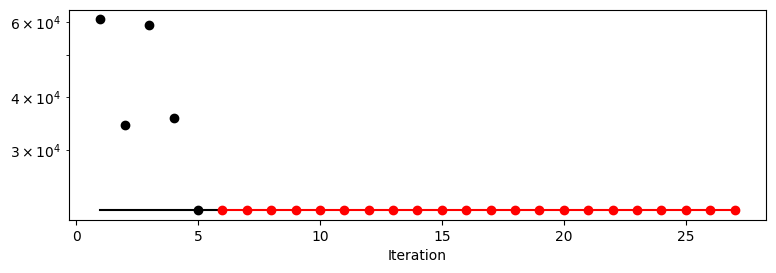

In [21]:
spot_tuner.plot_progress(log_y=True, filename="./figures/" + experiment_name+"_progress.pdf")

Results can also be printed in tabular form.


In [22]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                   | type   | default          |     lower |     upper | tuned                 | transform             |   importance | stars   |
|------------------------|--------|------------------|-----------|-----------|-----------------------|-----------------------|--------------|---------|
| grace_period           | int    | 200              |      10.0 |    1000.0 | 308.0                 | None                  |       100.00 | ***     |
| max_depth              | int    | 20               |       2.0 |      20.0 | 4.0                   | transform_power_2_int |         0.00 |         |
| delta                  | float  | 1e-07            |     1e-10 |     1e-06 | 7.744844892279623e-07 | None                  |        39.19 | *       |
| tau                    | float  | 0.05             |      0.01 |       0.1 | 0.04136387491162857   | None                  |        25.21 | *       |
| leaf_prediction        | factor | mean             |       0.0 |       2.0 | adaptive 

A histogram can be used to visualize the most important hyperparameters.


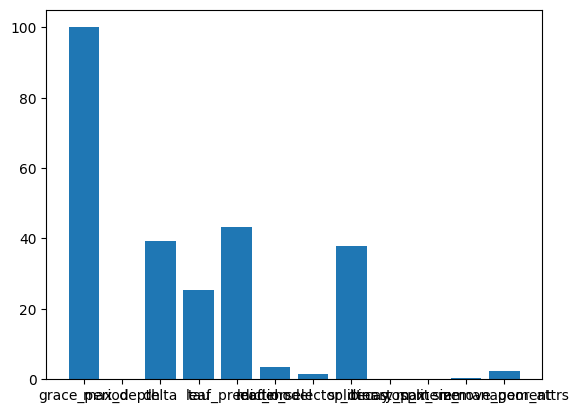

In [23]:
spot_tuner.plot_importance(threshold=0.0025, filename="./figures/" + experiment_name+"_importance.pdf")

In [24]:
spot_tuner.print_results()

min y: 21643.127765581303
grace_period: 308.0
max_depth: 4.0
delta: 7.744844892279623e-07
tau: 0.04136387491162857
leaf_prediction: 2.0
leaf_model: 0.0
model_selector_decay: 0.9436342844873347
splitter: 2.0
min_samples_split: 5.0
binary_split: 0.0
max_size: 907.5263122884716
memory_estimate_period: 1000000.0
stop_mem_management: 1.0
remove_poor_attrs: 0.0
merit_preprune: 0.0


[['grace_period', 308.0],
 ['max_depth', 4.0],
 ['delta', 7.744844892279623e-07],
 ['tau', 0.04136387491162857],
 ['leaf_prediction', 2.0],
 ['leaf_model', 0.0],
 ['model_selector_decay', 0.9436342844873347],
 ['splitter', 2.0],
 ['min_samples_split', 5.0],
 ['binary_split', 0.0],
 ['max_size', 907.5263122884716],
 ['memory_estimate_period', 1000000.0],
 ['stop_mem_management', 1.0],
 ['remove_poor_attrs', 0.0],
 ['merit_preprune', 0.0]]

In [25]:
from spotPython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(fun_control=fun_control, spot_tuner=spot_tuner)

{'grace_period': 308.0,
 'max_depth': 4.0,
 'delta': 7.744844892279623e-07,
 'tau': 0.04136387491162857,
 'leaf_prediction': 'adaptive',
 'leaf_model': 'LinearRegression',
 'model_selector_decay': 0.9436342844873347,
 'splitter': 'QOSplitter',
 'min_samples_split': 5.0,
 'binary_split': 0,
 'max_size': 907.5263122884716,
 'memory_estimate_period': 1000000.0,
 'stop_mem_management': 1,
 'remove_poor_attrs': 0,
 'merit_preprune': 0}

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 2.0
self.upper[j]: 20.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.2

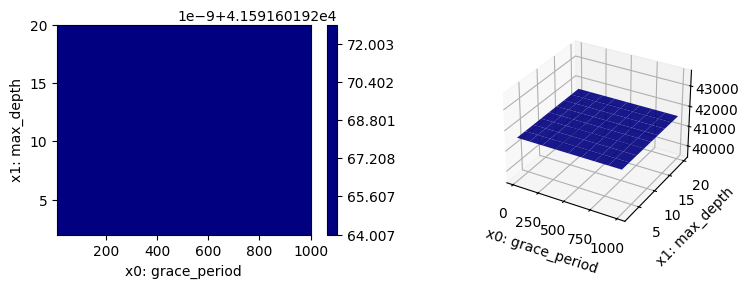

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 1e-10
self.upper[j]: 1e-06
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.

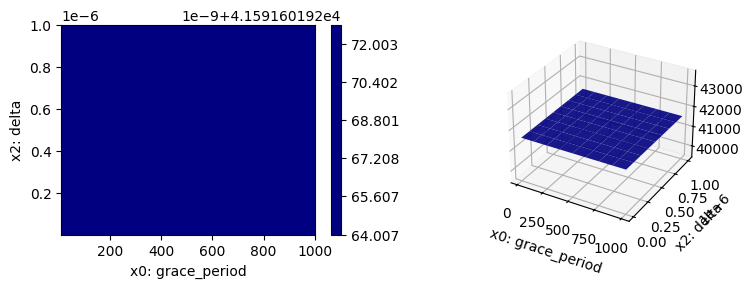

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.01
self.upper[j]: 0.1
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75

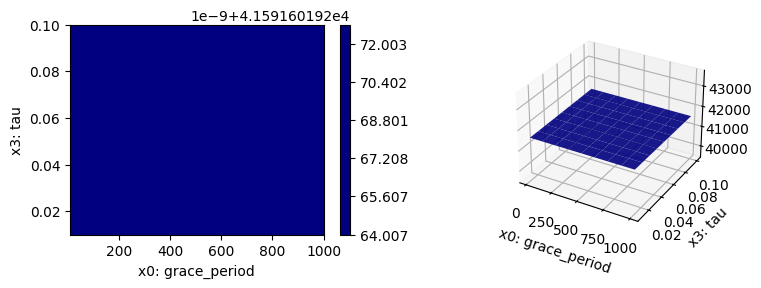

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25 

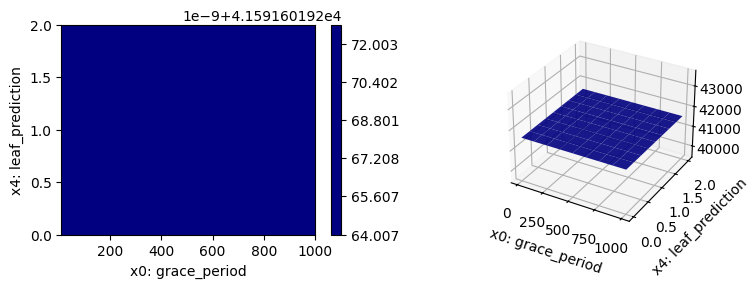

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25 

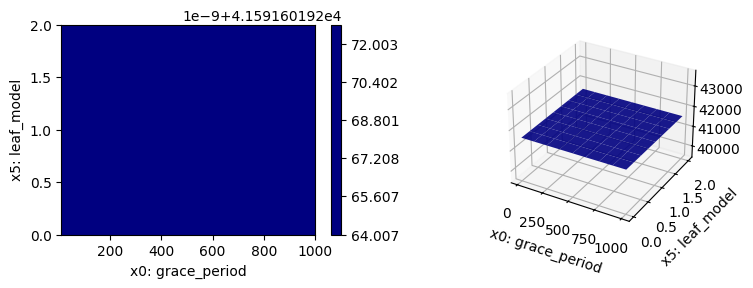

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.9
self.upper[j]: 0.99
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75

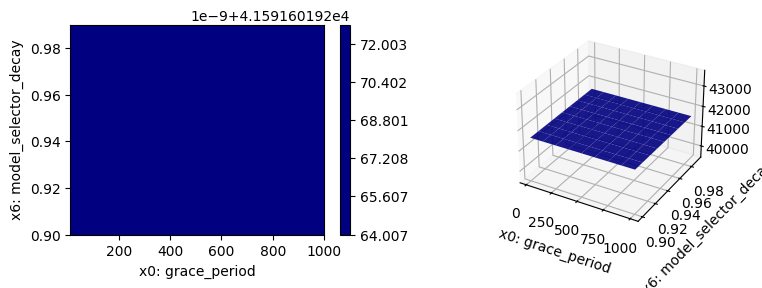

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25 

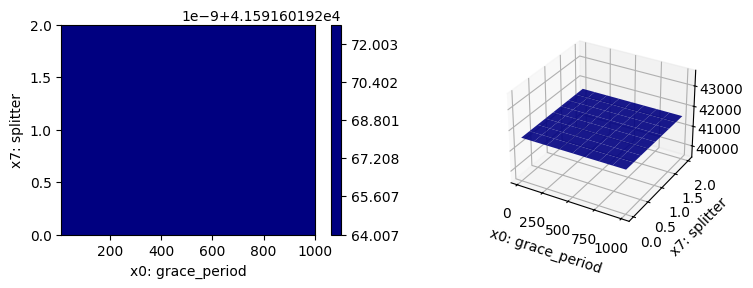

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25 

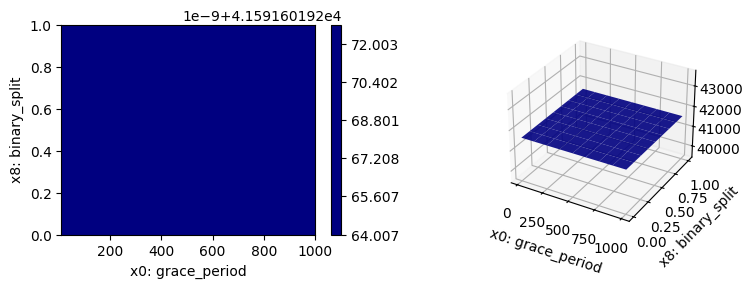

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   4

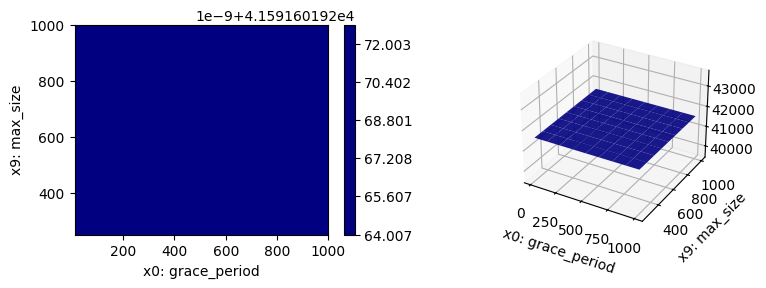

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25 

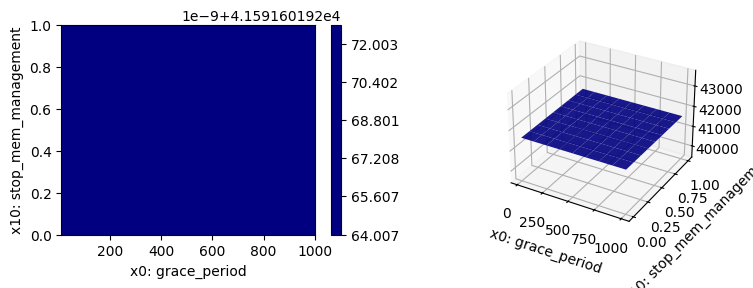

self.lower[i]: 10.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
  381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
  752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25   92.5   133.75  175.    216.25  257.5   298.75  340.
   381.25  422.5   463.75  505.    546.25  587.5   628.75  670.    711.25
   752.5   793.75  835.    876.25  917.5   958.75 1000.  ]
 [  10.     51.25 

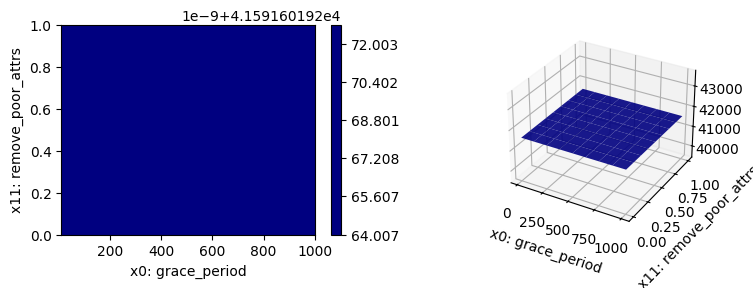

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 1e-10
self.upper[j]: 1e-06
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75

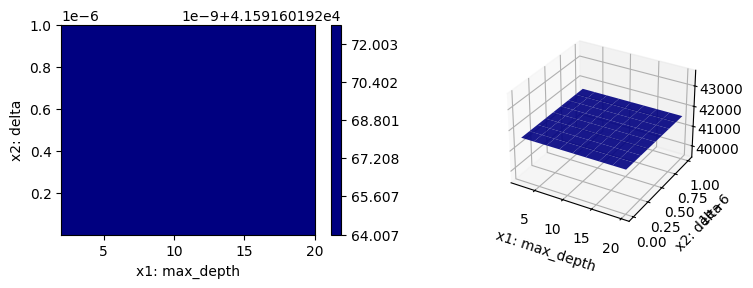

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.01
self.upper[j]: 0.1
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75

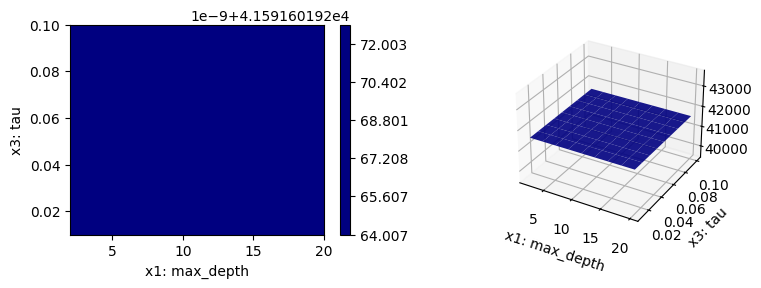

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.   

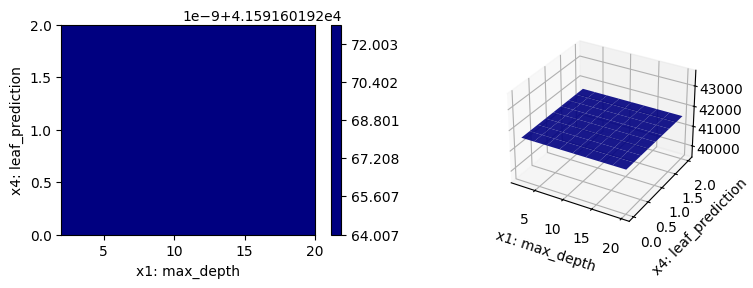

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.   

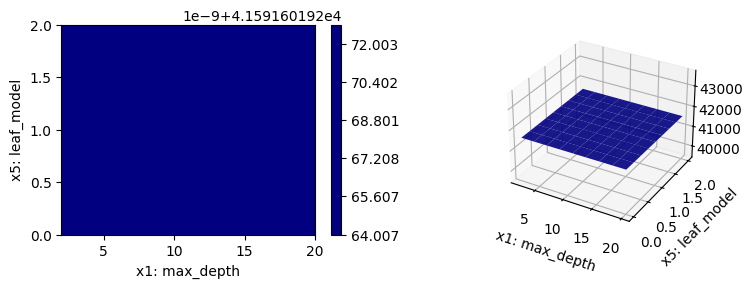

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.9
self.upper[j]: 0.99
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75

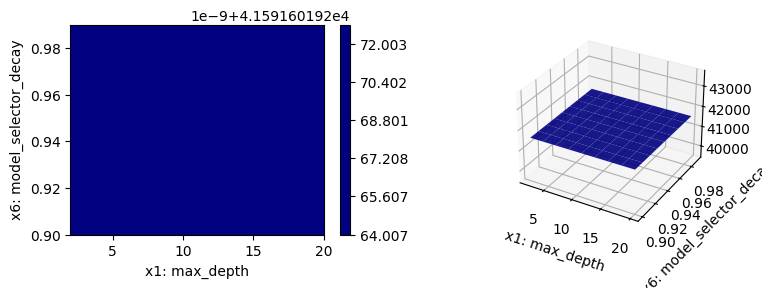

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.   

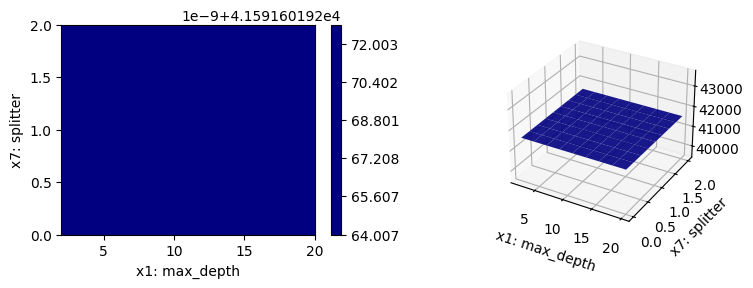

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.   

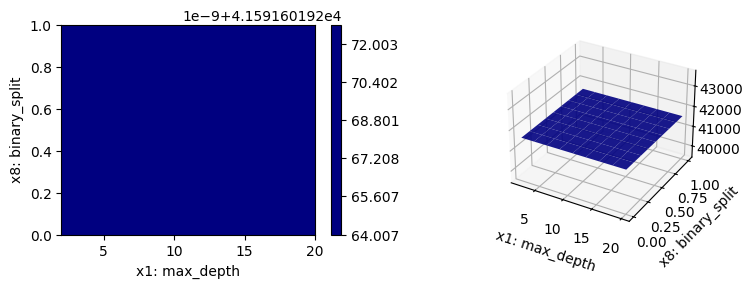

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   

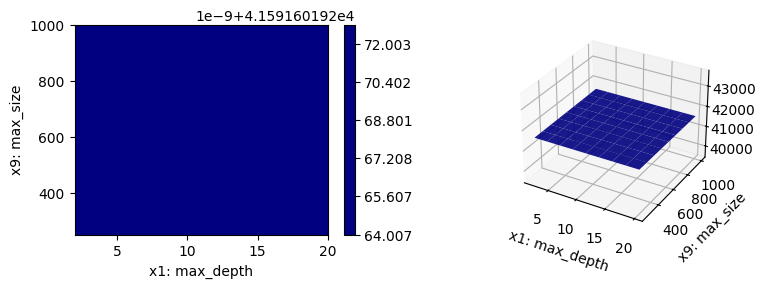

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.   

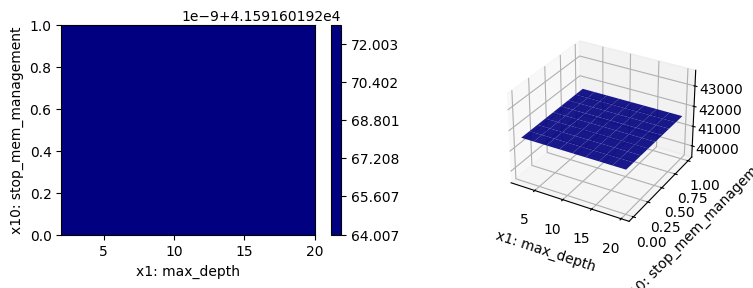

self.lower[i]: 2.0
self.upper[i]: 20.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
 11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
 20.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.    2.75  3.5   4.25  5.    5.75  6.5   7.25  8.    8.75  9.5  10.25
  11.   11.75 12.5  13.25 14.   14.75 15.5  16.25 17.   17.75 18.5  19.25
  20.  ]
 [ 2.   

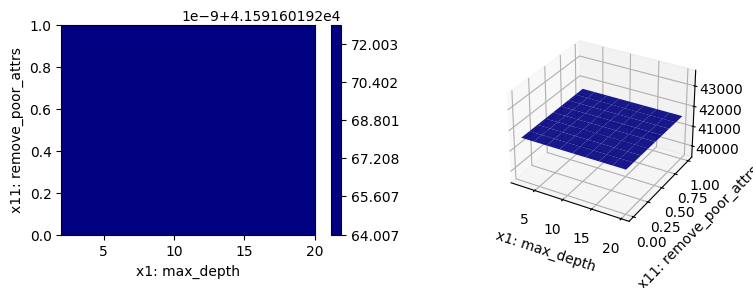

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.01
self.upper[j]: 0.1
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
 [1.000000e-10 4.176250e-08 8.342500e-08 1

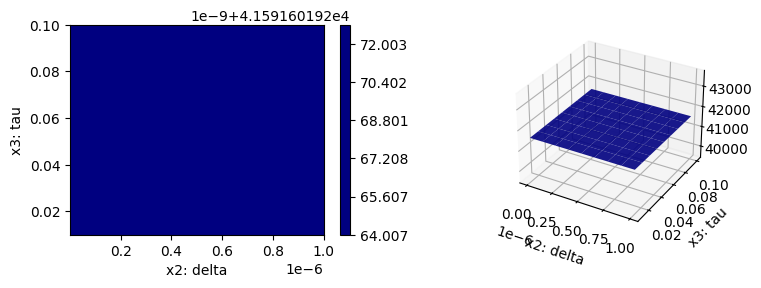

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.1

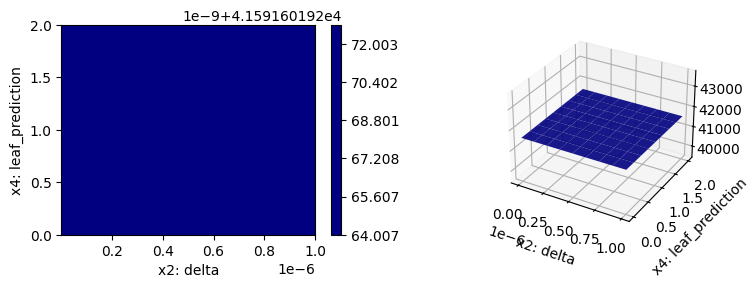

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.1

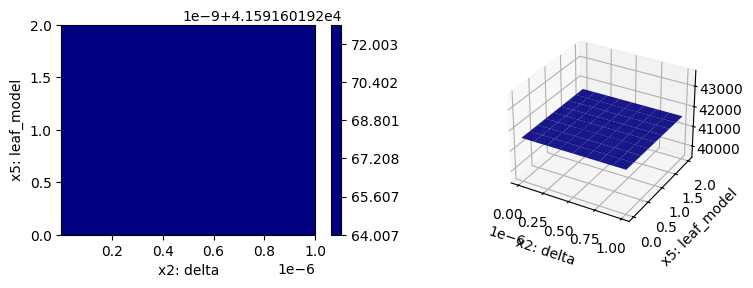

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.9
self.upper[j]: 0.99
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
 [1.000000e-10 4.176250e-08 8.342500e-08 1

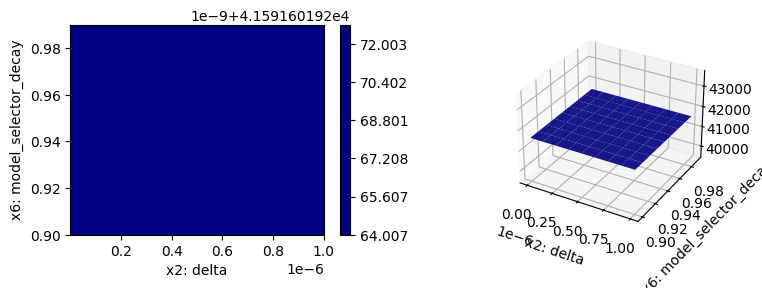

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.1

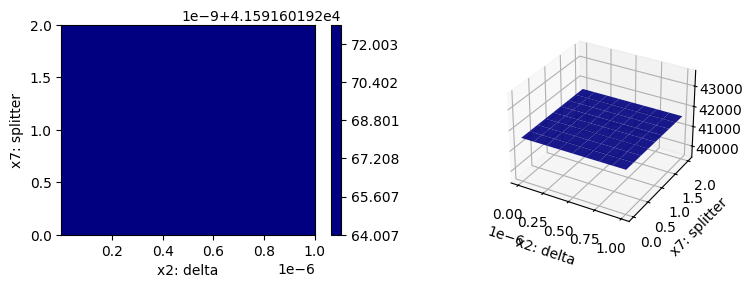

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.1

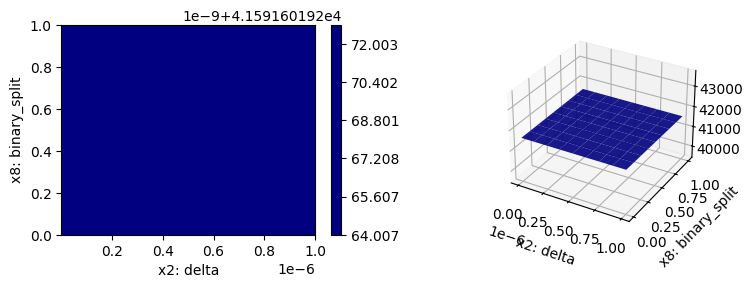

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
 [1.000000e-10 4.176250e-08 8.342500e

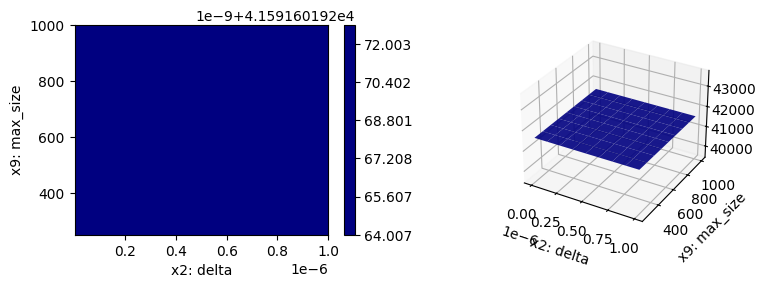

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.1

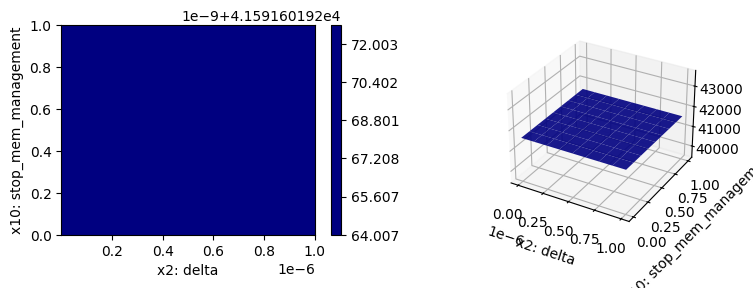

self.lower[i]: 1e-10
self.upper[i]: 1e-06
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
 2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
 4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
 6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
 8.333500e-07 8.750125e-07 9.166750e-07 9.583375e-07 1.000000e-06]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[1.000000e-10 4.176250e-08 8.342500e-08 1.250875e-07 1.667500e-07
  2.084125e-07 2.500750e-07 2.917375e-07 3.334000e-07 3.750625e-07
  4.167250e-07 4.583875e-07 5.000500e-07 5.417125e-07 5.833750e-07
  6.250375e-07 6.667000e-07 7.083625e-07 7.500250e-07 7.916875e-07
  8.333500e-07 8.750125e-07 9.1

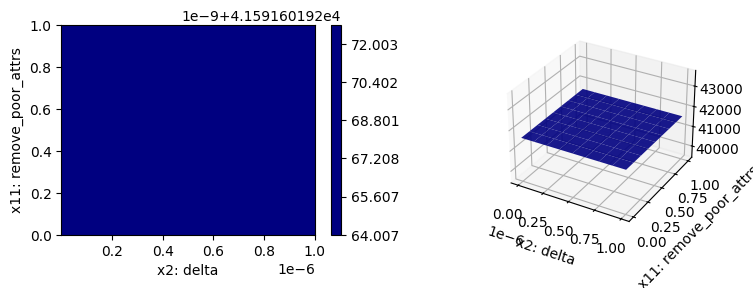

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175

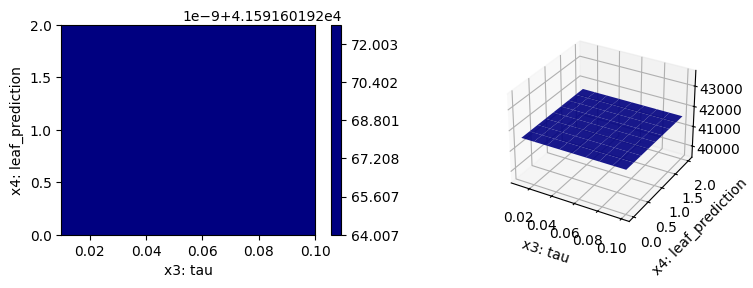

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175

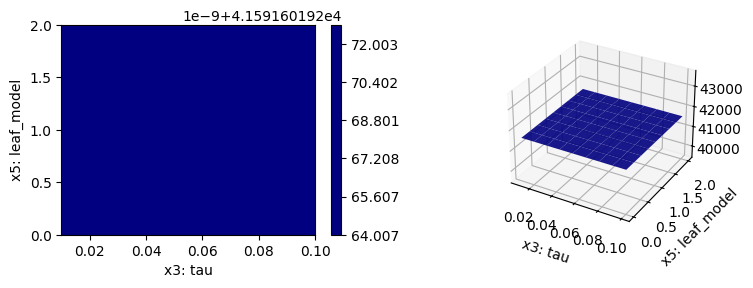

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.9
self.upper[j]: 0.99
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055 

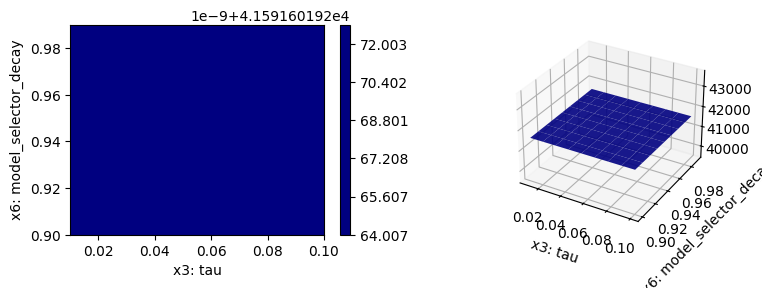

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175

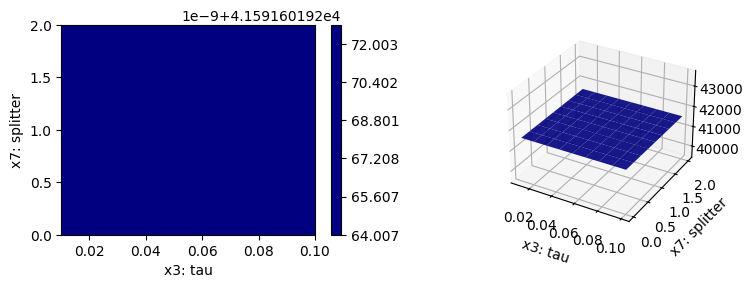

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175

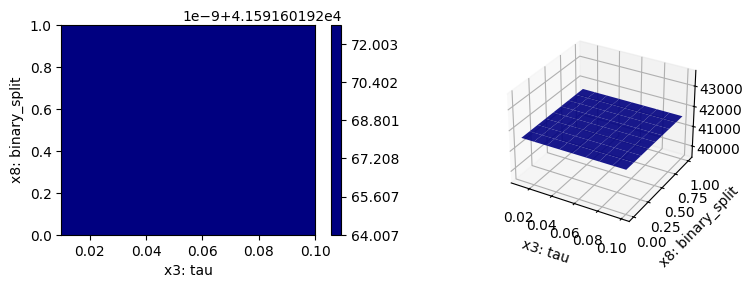

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0

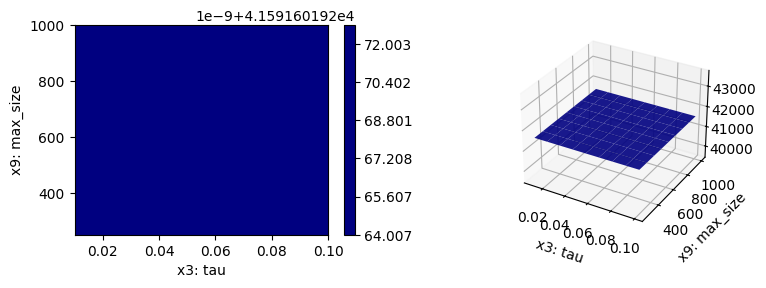

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175

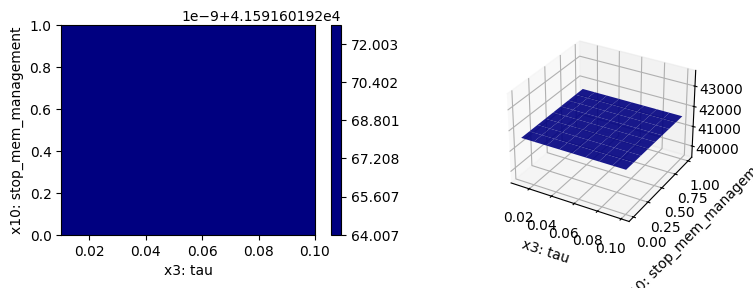

self.lower[i]: 0.01
self.upper[i]: 0.1
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
 0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
 0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175  0.02125 0.025   0.02875 0.0325  0.03625 0.04
  0.04375 0.0475  0.05125 0.055   0.05875 0.0625  0.06625 0.07    0.07375
  0.0775  0.08125 0.085   0.08875 0.0925  0.09625 0.1    ]
 [0.01    0.01375 0.0175

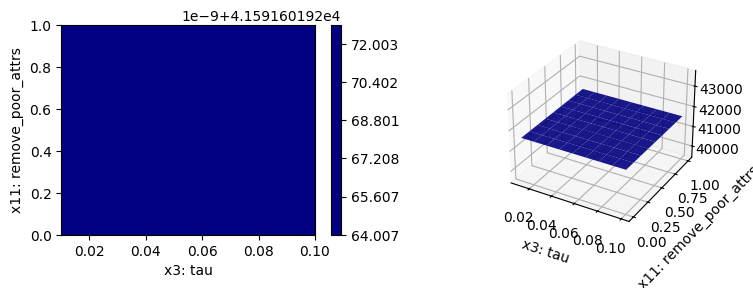

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

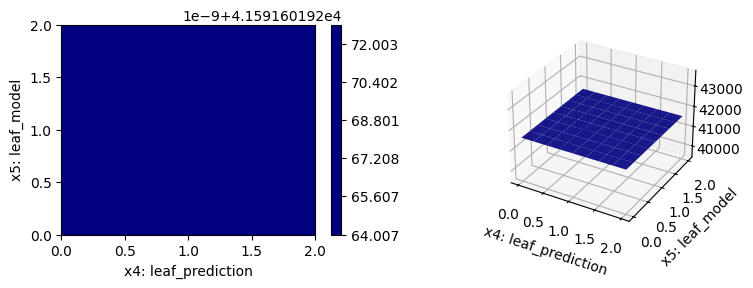

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.9
self.upper[j]: 0.99
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.      

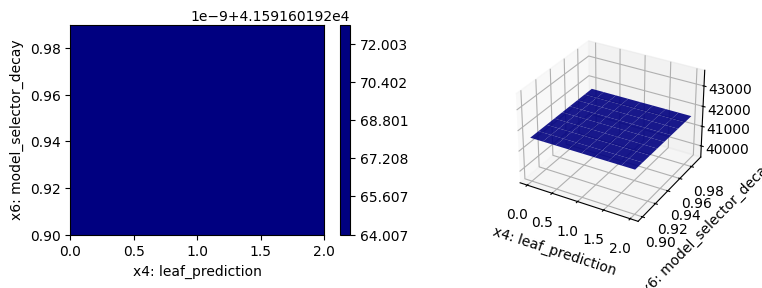

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

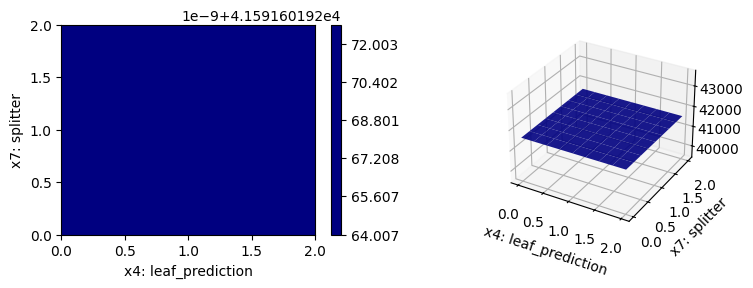

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

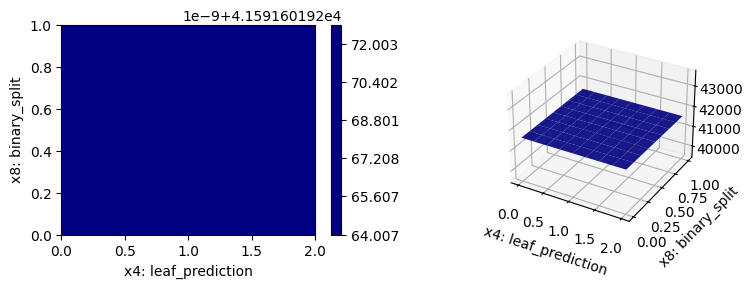

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1. 

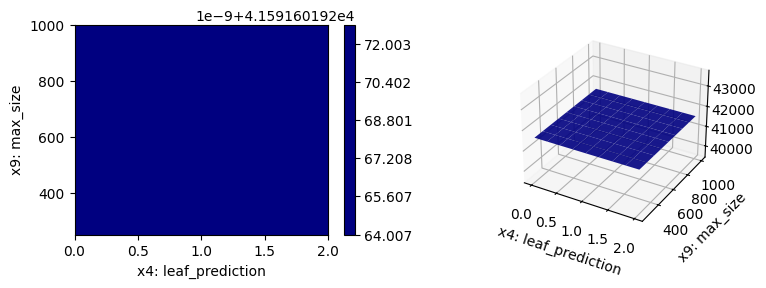

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

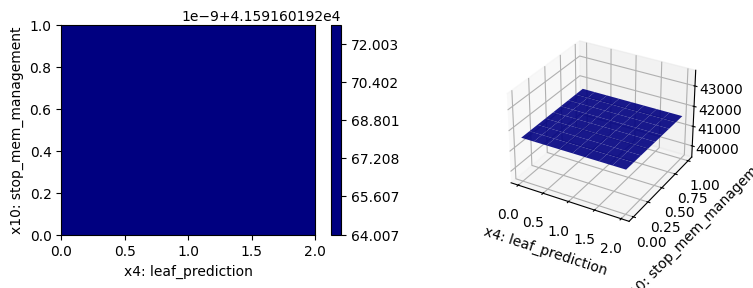

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

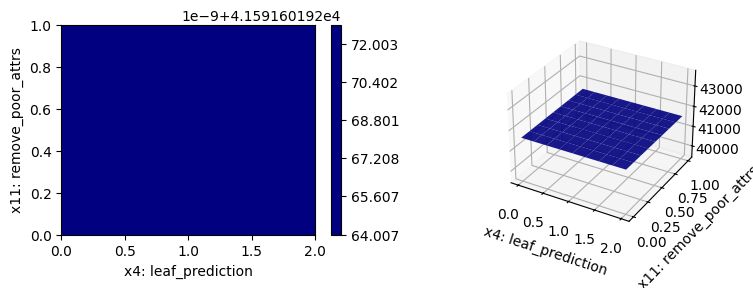

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.9
self.upper[j]: 0.99
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.      

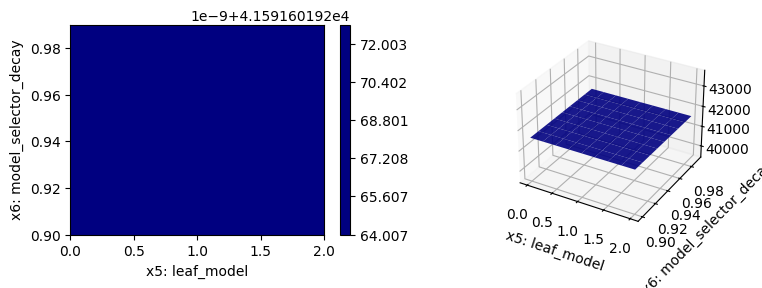

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

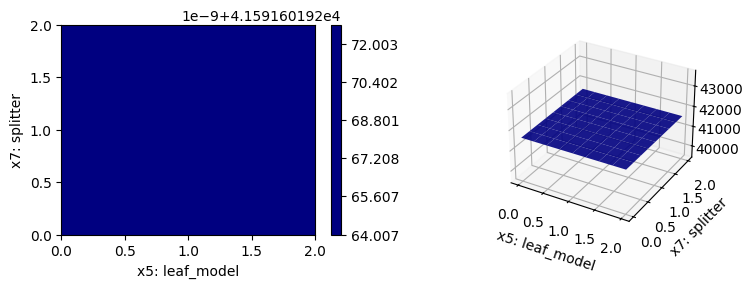

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

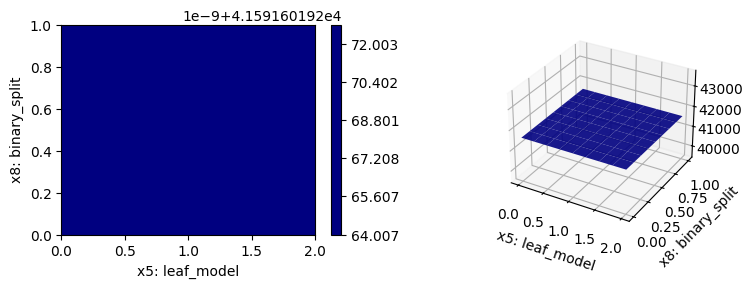

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1. 

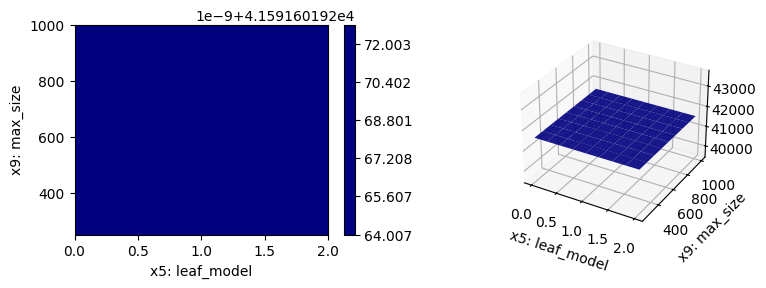

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

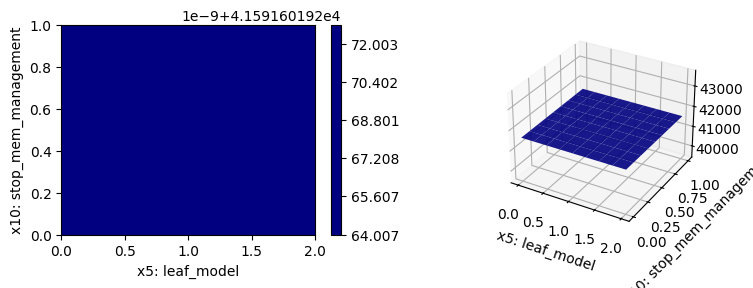

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

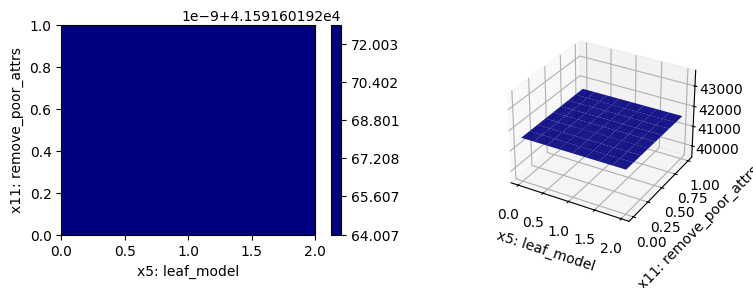

self.lower[i]: 0.9
self.upper[i]: 0.99
self.lower[j]: 0.0
self.upper[j]: 2.0
x: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
y: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
X: [[0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075

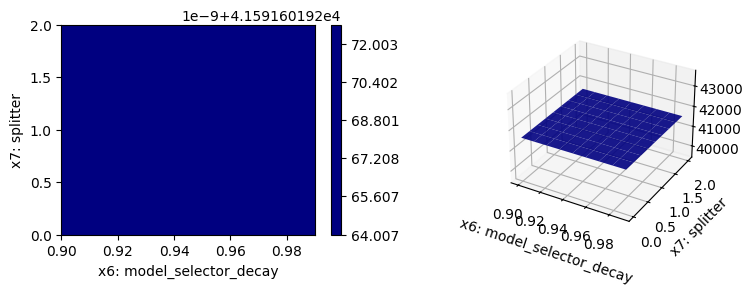

self.lower[i]: 0.9
self.upper[i]: 0.99
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075

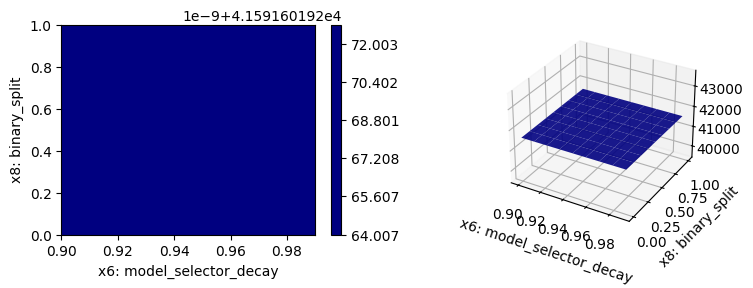

self.lower[i]: 0.9
self.upper[i]: 0.99
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0

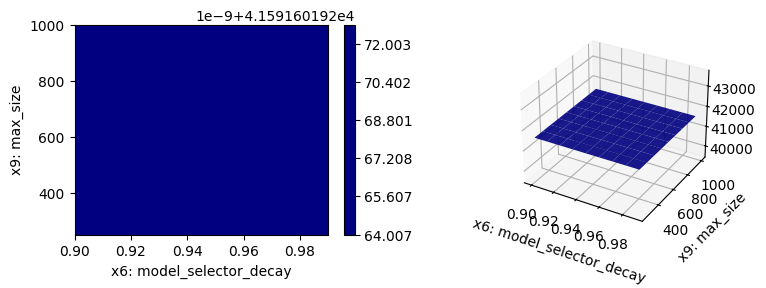

self.lower[i]: 0.9
self.upper[i]: 0.99
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075

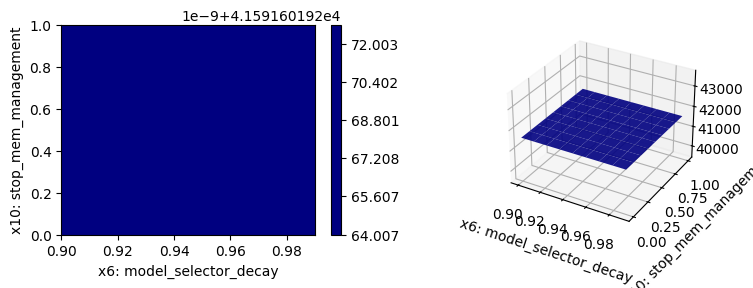

self.lower[i]: 0.9
self.upper[i]: 0.99
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
 0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
 0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075  0.91125 0.915   0.91875 0.9225  0.92625 0.93
  0.93375 0.9375  0.94125 0.945   0.94875 0.9525  0.95625 0.96    0.96375
  0.9675  0.97125 0.975   0.97875 0.9825  0.98625 0.99   ]
 [0.9     0.90375 0.9075

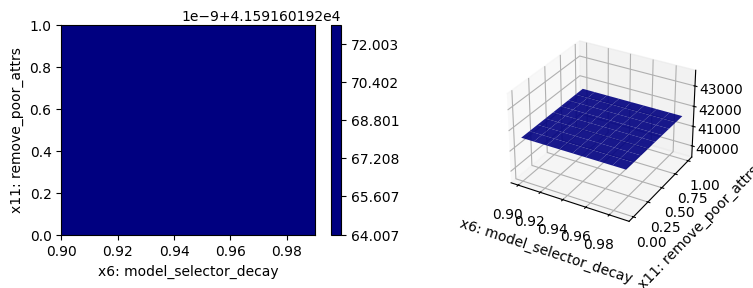

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

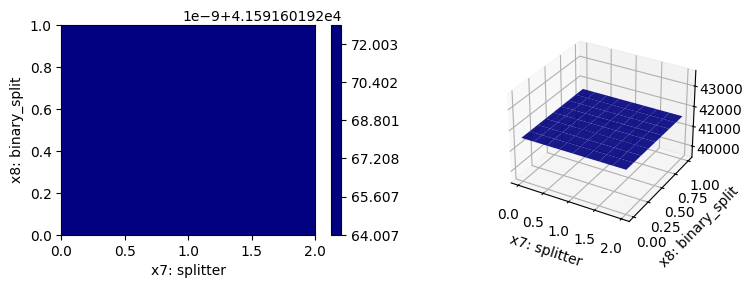

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1. 

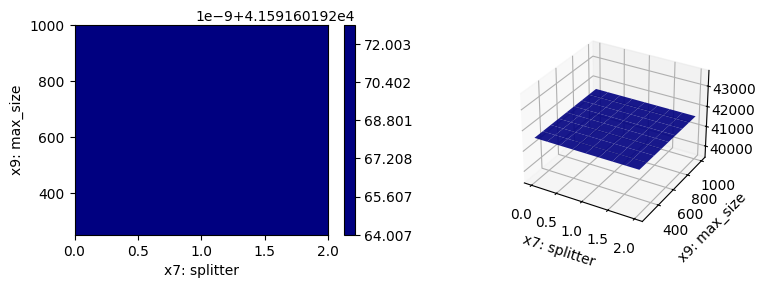

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

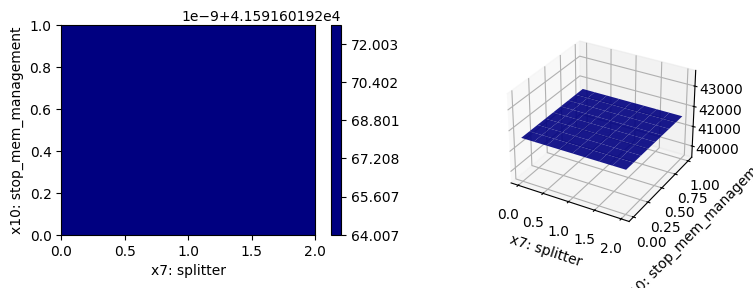

self.lower[i]: 0.0
self.upper[i]: 2.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
  0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
  1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
  1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
  2.        ]
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667

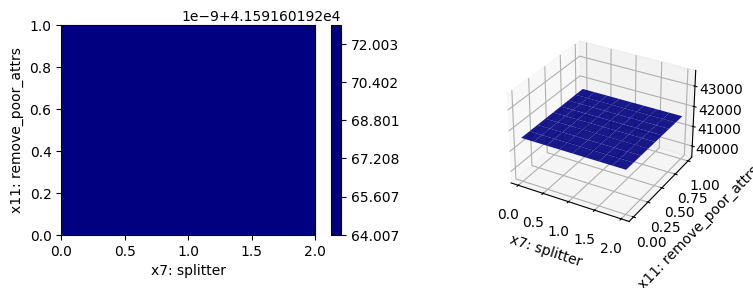

self.lower[i]: 0.0
self.upper[i]: 1.0
self.lower[j]: 250.0
self.upper[j]: 1000.0
x: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
y: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
X: [[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
  0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
  0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
  0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
  1.        ]
 [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
  0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
  0.5

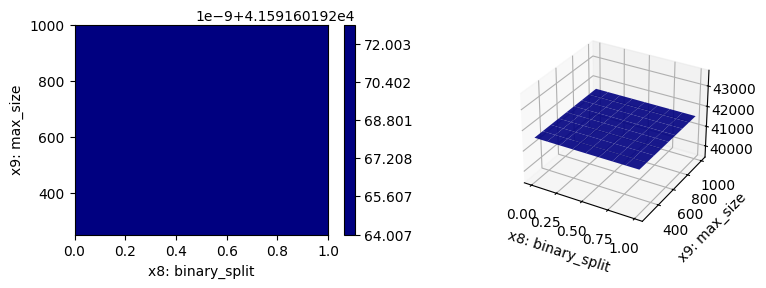

self.lower[i]: 0.0
self.upper[i]: 1.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
  0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
  0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
  0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
  1.        ]
 [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333

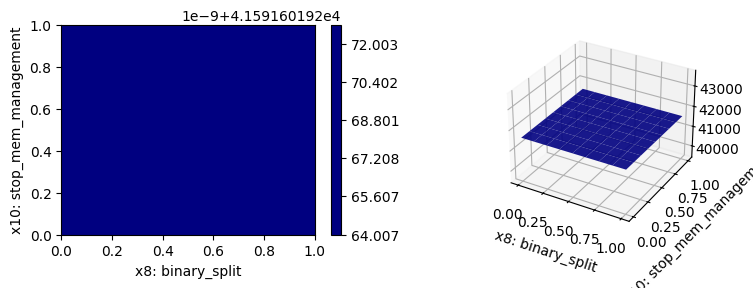

self.lower[i]: 0.0
self.upper[i]: 1.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
  0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
  0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
  0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
  1.        ]
 [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333

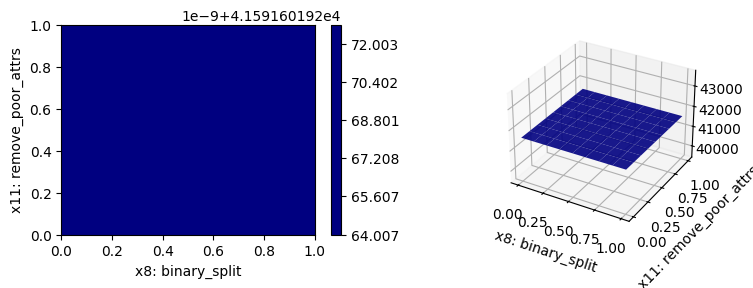

self.lower[i]: 250.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
   531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
   812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
 [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
   531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
   812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
 [ 250.    281.25

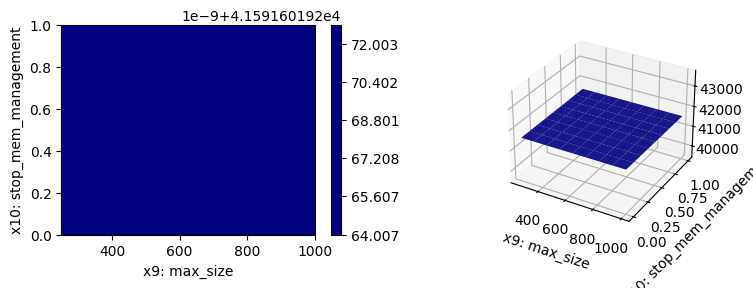

self.lower[i]: 250.0
self.upper[i]: 1000.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
  531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
  812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
   531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
   812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
 [ 250.    281.25  312.5   343.75  375.    406.25  437.5   468.75  500.
   531.25  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25
   812.5   843.75  875.    906.25  937.5   968.75 1000.  ]
 [ 250.    281.25

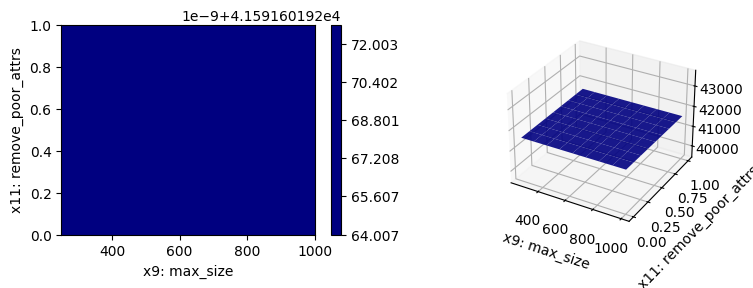

self.lower[i]: 0.0
self.upper[i]: 1.0
self.lower[j]: 0.0
self.upper[j]: 1.0
x: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
y: [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
X: [[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
  0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
  0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
  0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
  1.        ]
 [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333

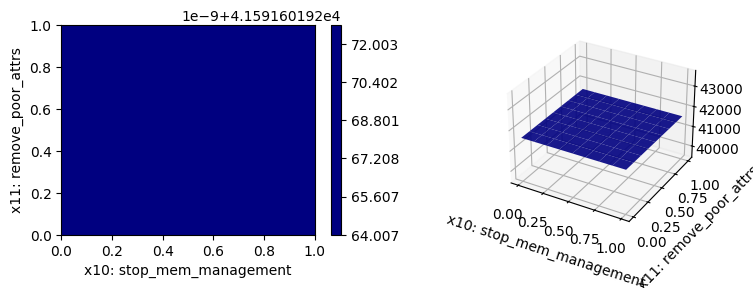

In [26]:
PLOT_ALL = True
min_z = None
max_z = None
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, verbosity=1)

## The Larger Data Set 

After the hyperparamter were tuned on a small data set, we can now apply the hyperparameter configuration to a larger data set. The following code snippet shows how to generate the larger data set.

:::{.callout-caution}
#### Caution: Increased Friedman-Drift Data Set

* The Friedman-Drift Data Set is increased by a factor of two to show the transferability of the hyperparameter tuning results.
* Larger values of `K` lead to a longer run time.
:::


In [27]:
K = 0.2
n_samples = int(K*100_000)
p_1 = int(K*25_000)
p_2 = int(K*50_000)
position=(p_1, p_2)

In [28]:
dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=123
)

The larger data set is converted to a Pandas data frame and passed to the `fun_control` dictionary.


In [29]:
df = convert_to_df(dataset, target_column=target_column, n_total=n_samples)
df.columns = [f"x{i}" for i in range(1, 11)] + ["y"]
set_control_key_value(fun_control, "train", df[:n_train], True)
set_control_key_value(fun_control, "test", df[n_train:], True)
set_control_key_value(fun_control, "n_samples", n_samples, True)
set_control_key_value(fun_control, "target_column", target_column, True)

## Get Default Hyperparameters

The default hyperparameters, whihc will be used for a comparion with the tuned hyperparameters, can be obtained with the following commands:


In [30]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
model_default = get_one_core_model_from_X(X_start, fun_control)
model_default

!!! Warning:  1 is not in list
Did you modify lower and upper bounds so that the default values are not included?
Returning 'None'.


TypeError: 'NoneType' object is not subscriptable

:::{.callout-note}
#### Note: `spotPython` tunes numpy arrays
* `spotPython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.
::::

The model with the default hyperparameters can be trained and evaluated with the following commands:


In [ ]:
from spotRiver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., scaoe (metric), runtime, and memory consumption, can be visualized with the following commands:


In [ ]:
from spotRiver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

### Show Predictions

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.


In [ ]:
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)

In [ ]:
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotPython`.


In [ ]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [ ]:
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

In [ ]:
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"], filename="./figures/" + experiment_name+"_metrics.pdf")

In [ ]:
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_predictions.pdf")

In [ ]:
from spotPython.plot.validation import plot_actual_vs_predicted
plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Visualize Regression Trees


In [ ]:
dataset_f = dataset.take(n_samples)
for x, y in dataset_f:
    model_default.learn_one(x, y)

:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::


In [ ]:
# model_default.draw()

In [ ]:
model_default.summary

### Spot Model


In [ ]:
dataset_f = dataset.take(n_samples)
for x, y in dataset_f:
    model_spot.learn_one(x, y)

:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::


In [ ]:
# model_spot.draw()

In [ ]:
model_spot.summary

In [ ]:
from spotPython.utils.eda import compare_two_tree_models
print(compare_two_tree_models(model_default, model_spot))

## Detailed Hyperparameter Plots


In [ ]:
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

## Parallel Coordinates Plots


In [ ]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.


In [ ]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)